<h1><center><font size="6">Cats or Dogs - using CNN with Transfer Learning</font></center></h1>


<center><img src="https://www.theladders.com/wp-content/uploads/dog-cat-190709-1000x563.jpg" width="900"></img></center>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages and set parameters</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Data exploration</a>
    - <a href='#41'>Class distribution</a>
    - <a href='#42'>Images samples</a>
- <a href='#5'>Model</a>  
    - <a href='#51'>Prepare the model</a>  
    - <a href='#52'>Train the model</a>  
    - <a href='#53'>Validation accuracy and loss</a>  
    - <a href='#54'>Validation accuracy per class</a>  
- <a href='#6'>Prepare submission</a>     
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>



# <a id="1">Introduction</a>  


## Dataset

The **train** folder contains **25,000** images of **dogs** and **cats**. Each image in this folder has the label as part of the filename. The **test** folder contains **12,500** images, named according to a numeric id.  
For each image in the test set, you should predict a probability that the image is a dog (**1** = **dog**, **0** = **cat**).


## Method

For the solution of this problem we will use a pre-trained model, ResNet-50, replacing only the last layer.

# <a id="2">Load packages</a>

In [2]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

Using TensorFlow backend.


In [3]:
!python3 --version

Python 3.6.6 :: Anaconda, Inc.


In [4]:
 !pip show tensorflow

Name: tensorflow
Version: 1.10.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /opt/conda/lib/python3.6/site-packages
Requires: termcolor, keras-preprocessing, grpcio, absl-py, protobuf, setuptools, six, gast, wheel, tensorboard, keras-applications, astor, numpy
Required-by: fancyimpute, ethnicolr


In [5]:
!pip show keras

Name: Keras
Version: 2.2.2
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.6/site-packages
Requires: numpy, pyyaml, h5py, six, keras-applications, keras-preprocessing, scipy
Required-by: keras-tqdm, ethnicolr


## Parameters

Here we set few parameters used in the model. The image size is **224**.    
The images are stored in two folders, **train** and **test**.  
There are two image classes: **Dog** and **Cat**.  
We will use a subset of the training data set (**20,000** images).  From the training set, **50%** will be used for training, **50%** for validation.  
A pre-trained model from **ResNet-50** will be used.  
A number of **10** epochs will be used for training.  



In [6]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 20
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224
RESNET_WEIGHTS_PATH = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# <a id="3">Read the data</a>

We set the train image list.   
Setting the **SAMPLE_SIZE** value we can reduce/enlarge the size of the training set.    
Currently **SAMPLE_SIZE** is set to **20,000**.


In [7]:
train_image_path = os.path.join(PATH, "train.zip")
print(train_image_path)
test_image_path = os.path.join(PATH, "test.zip")
print(test_image_path)

/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [8]:
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")

In [9]:
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [10]:
count = 0
train_image_list = os.listdir("./train/")[0:SAMPLE_SIZE]
while count < 10:
    print(f"train: {train_image_list[count]}")
    count+=1
count = 0
test_image_list = os.listdir("./test/")
while count <= 10:
    print(f"test: {test_image_list[count]}")
    count+=1

train: cat.3398.jpg
train: cat.6329.jpg
train: dog.11065.jpg
train: dog.8027.jpg
train: dog.2964.jpg
train: cat.4422.jpg
train: cat.9648.jpg
train: dog.7050.jpg
train: cat.844.jpg
train: dog.3391.jpg
test: 11479.jpg
test: 11527.jpg
test: 6934.jpg
test: 7497.jpg
test: 4371.jpg
test: 2778.jpg
test: 335.jpg
test: 5049.jpg
test: 622.jpg
test: 6320.jpg
test: 4713.jpg


We set a function for parsing the image names to extract the first 3 letters from the image names, which gives the label of the image. It will be either a cat or a dog. We are using one hot encoder, storing [1,0] for **cat** and [0,1] for **dog**.

In [11]:
def label_pet_image_one_hot_encoder(img):  
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [12]:
label_pet_image_one_hot_encoder("cat.9190.jpg")

[1, 0]

We are defining as well a function to process the data (both train and test set). 

In [13]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    debag = True
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        if debag: print(f"Image: {label}\nSet there is train: {isTrain}")
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if debag: print(f"img: {img}")
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
        if debag: 
            print(f"img: {img}")
            print(f"data_df: {data_df}")
        debag = False
    shuffle(data_df)
    return data_df

# <a id="4">Data exploration</a>


## <a id="41">Class distribution</a>

Let's inspect the train data to check the **cat**/**dog** distribution.   We show first the split in the reduced train data.

In [14]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
         labels.append(img.split('.')[-3])  # Create labels from images name
    sns.countplot(labels)  # Counte labels and visualize
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

Let's show also the class distribution in the full train data set.

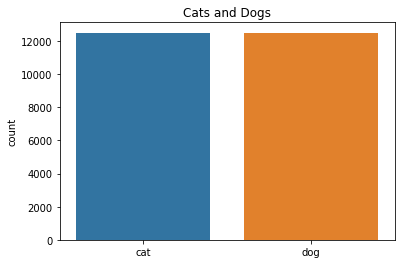

In [15]:
plot_image_list_count(os.listdir(TRAIN_FOLDER))  # listdir - will return a list of all files and directories in the directory specified by TRAIN_FOLDER.

## <a id="42">Images samples</a>

Let's represet some of the images. We start with a selection from the train set. We will show the first 25 images from the train set.

First,  we process the train data, reading the images and creating a table with images and labels. If the data is trom train set, the label is the one calculated with one hot encoding; if the data is from test set, the label will be the image number.

In [16]:
train = process_data(train_image_list, TRAIN_FOLDER)

  0%|          | 56/20000 [00:00<01:11, 277.19it/s]

Image: [1, 0]
Set there is train: True
img: [[[ 12  10   9]
  [  9   7   6]
  [ 15  16  14]
  ...
  [122 136 164]
  [114 128 156]
  [108 122 150]]

 [[ 15  16  14]
  [ 12  13  11]
  [ 18  21  19]
  ...
  [120 134 162]
  [115 129 157]
  [112 126 154]]

 [[ 20  25  23]
  [ 17  22  20]
  [ 24  31  28]
  ...
  [120 134 162]
  [118 132 160]
  [116 130 158]]

 ...

 [[ 63  68  69]
  [ 61  66  67]
  [ 64  68  69]
  ...
  [ 34  39  37]
  [ 36  41  39]
  [ 37  42  40]]

 [[ 61  66  67]
  [ 61  66  67]
  [ 69  75  74]
  ...
  [ 33  38  36]
  [ 35  40  38]
  [ 35  40  38]]

 [[ 56  64  64]
  [ 65  73  73]
  [ 94 100  99]
  ...
  [ 34  37  35]
  [ 35  38  36]
  [ 36  39  37]]]
img: [[[ 12  10   9]
  [ 10   8   7]
  [ 10   8   7]
  ...
  [115 129 157]
  [111 125 153]
  [108 122 150]]

 [[ 13  11  10]
  [ 11  10   9]
  [ 11  10   8]
  ...
  [115 129 157]
  [111 125 153]
  [109 123 151]]

 [[ 14  14  13]
  [ 13  13  11]
  [ 12  13  11]
  ...
  [116 130 158]
  [113 127 155]
  [111 125 153]]

 ...

 [[

100%|██████████| 20000/20000 [00:50<00:00, 393.26it/s]


Then, we plot the image selection.

img_num: [0 1]
img_data:[[[ 27 127 132]
  [ 27 127 132]
  [ 27 127 132]
  ...
  [109 156 164]
  [110 157 165]
  [109 156 164]]

 [[ 24 125 130]
  [ 24 125 130]
  [ 24 125 130]
  ...
  [108 155 163]
  [109 156 164]
  [108 155 163]]

 [[ 26 126 131]
  [ 26 126 131]
  [ 26 126 131]
  ...
  [110 157 165]
  [111 158 166]
  [110 157 165]]

 ...

 [[110 125 136]
  [ 85  97 104]
  [ 61  67  69]
  ...
  [206 206 206]
  [209 209 209]
  [208 208 208]]

 [[101 117 130]
  [ 77  88  95]
  [ 30  36  35]
  ...
  [207 204 205]
  [203 201 201]
  [204 202 202]]

 [[ 81 100 111]
  [ 61  72  73]
  [ 15  22  12]
  ...
  [208 202 203]
  [212 204 205]
  [215 207 208]]]
label: 1
str_label: Dog
img_num: [1 0]
img_data:[[[ 82  88  95]
  [ 81  87  94]
  [ 81  87  94]
  ...
  [123 131 138]
  [125 133 140]
  [122 131 135]]

 [[ 82  88  95]
  [ 81  87  94]
  [ 81  87  94]
  ...
  [123 131 138]
  [124 132 139]
  [122 131 135]]

 [[ 82  88  95]
  [ 81  87  94]
  [ 81  87  94]
  ...
  [123 131 138]
  [124 131 139]
  [1

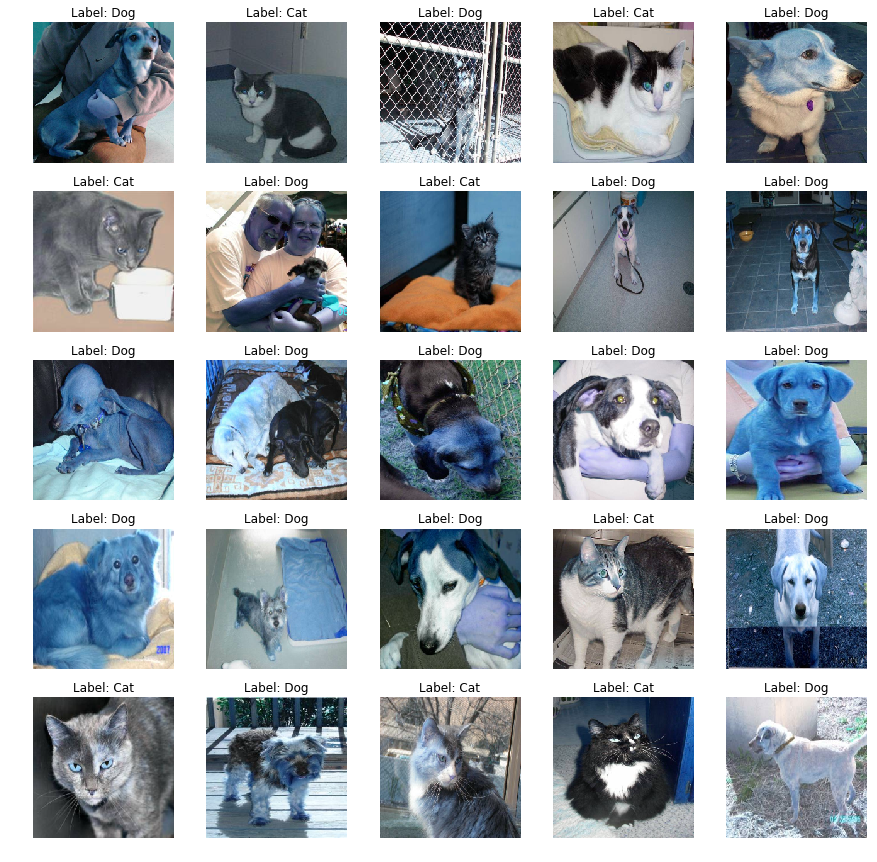

In [17]:
def show_images(data, isTest=False):
    count = 0
    # plt.subplots(5, 5) creates a 5x5 grid of subplots (i.e., 25 subplots in total).
    # f is the Figure object that contains all the subplots.
    # ax is a 2D array of Axes objects, where each Axes object corresponds to an individual subplot.
    f, ax = plt.subplots(5,5, figsize=(15,15)) 
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 1: 
            str_label="Dog"
        elif label == 0: 
            str_label="Cat"
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis("off")
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
        if count < 4:
            print(f"img_num: {img_num}\nimg_data:{img_data}\nlabel: {label}\nstr_label: {str_label}")
        count += 1
    plt.show()

show_images(train)

Let's also show a selection of the train set. We prepare the test set.

In [18]:
test = process_data(test_image_list, TEST_FOLDER, False)

  0%|          | 38/12500 [00:00<00:33, 374.62it/s]

Image: 11479
Set there is train: False
img: [[[110 128 135]
  [147 165 172]
  [116 134 141]
  ...
  [172 164 174]
  [172 164 174]
  [171 163 173]]

 [[ 97 115 122]
  [123 141 148]
  [103 121 128]
  ...
  [175 167 177]
  [172 167 176]
  [174 166 176]]

 [[103 122 129]
  [110 129 136]
  [100 120 125]
  ...
  [180 175 184]
  [177 174 183]
  [179 174 183]]

 ...

 [[174 189 205]
  [173 188 204]
  [176 189 205]
  ...
  [ 97  96 112]
  [ 74  73  89]
  [ 68  67  83]]

 [[172 187 203]
  [173 186 202]
  [175 185 202]
  ...
  [ 77  76  92]
  [ 54  53  69]
  [ 48  47  63]]

 [[171 184 200]
  [170 183 199]
  [173 183 200]
  ...
  [ 68  66  85]
  [ 45  43  62]
  [ 39  37  56]]]
img: [[[110 128 135]
  [116 134 141]
  [132 150 157]
  ...
  [172 163 173]
  [171 163 173]
  [171 163 173]]

 [[110 128 135]
  [116 134 141]
  [132 150 157]
  ...
  [171 163 173]
  [171 163 173]
  [171 163 173]]

 [[105 123 131]
  [111 129 136]
  [126 144 151]
  ...
  [172 164 174]
  [172 164 174]
  [172 164 174]]

 ...

 [[

100%|██████████| 12500/12500 [00:31<00:00, 398.37it/s]


Then, we show a selection of the test set.

In [19]:
show_images(test,True)

img_num: 3342
img_data:[[[201 145 128]
  [198 142 125]
  [196 140 123]
  ...
  [128  94  79]
  [133 115 103]
  [100  85  83]]

 [[210 151 135]
  [208 148 132]
  [206 147 131]
  ...
  [130  95  83]
  [123 104  94]
  [ 96  83  81]]

 [[214 155 136]
  [212 153 134]
  [212 153 134]
  ...
  [116  85  76]
  [119  96  90]
  [ 94  82  82]]

 ...

 [[125 132 182]
  [121 131 178]
  [133 141 180]
  ...
  [182 134 130]
  [179 131 127]
  [172 128 121]]

 [[134 136 186]
  [122 129 179]
  [120 133 178]
  ...
  [179 131 127]
  [175 128 124]
  [168 126 119]]

 [[141 138 190]
  [126 131 184]
  [115 129 179]
  ...
  [175 128 124]
  [171 125 120]
  [165 123 116]]]
label: 0
str_label: None
img_num: 11964
img_data:[[[ 46  49  38]
  [ 54  56  41]
  [ 48  48  34]
  ...
  [122 104  95]
  [121 106  93]
  [107  94  81]]

 [[ 44  41  32]
  [ 50  49  35]
  [ 44  41  27]
  ...
  [111 101  91]
  [112  98  86]
  [142 128 116]]

 [[ 77  64  60]
  [ 85  74  66]
  [ 67  57  44]
  ...
  [ 79  75  64]
  [ 86  75  65]
  [1

# <a id="5">Model</a>

## <a id="51">Prepare the model</a>

Let's start by preparing the model.

### Prepare the train data

In [20]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])
print(f"X train: {X[0]}\ny train: {y[0]}")

X train: [[[ 27 127 132]
  [ 27 127 132]
  [ 27 127 132]
  ...
  [109 156 164]
  [110 157 165]
  [109 156 164]]

 [[ 24 125 130]
  [ 24 125 130]
  [ 24 125 130]
  ...
  [108 155 163]
  [109 156 164]
  [108 155 163]]

 [[ 26 126 131]
  [ 26 126 131]
  [ 26 126 131]
  ...
  [110 157 165]
  [111 158 166]
  [110 157 165]]

 ...

 [[110 125 136]
  [ 85  97 104]
  [ 61  67  69]
  ...
  [206 206 206]
  [209 209 209]
  [208 208 208]]

 [[101 117 130]
  [ 77  88  95]
  [ 30  36  35]
  ...
  [207 204 205]
  [203 201 201]
  [204 202 202]]

 [[ 81 100 111]
  [ 61  72  73]
  [ 15  22  12]
  ...
  [208 202 203]
  [212 204 205]
  [215 207 208]]]
y train: [0 1]


### Prepare the model

We initialize the **ResNet-50** model, adding an additional last layer of type **Dense**, with **softmax** activation function.   

We also set the first layer of the model to be not trainable, becaise **ResNet-50** model was already trained.

In [ ]:
model = Sequential() # Creates a new Sequential model. This model is a linear stack of layers where you can add one layer at a time.

# Adds a ResNet50 model as a layer to the Sequential model.
# include_top=False means that the top (fully connected) layers of ResNet50 are not included, which is typically done 
# when you want to use the network as a feature extractor (excluding the final classification layers).
# pooling='max' adds a Global Max Pooling layer after the ResNet50 model, which helps in reducing the dimensionality of the output.
# weights=RESNET_WEIGHTS_PATH initializes the model with pre-trained weights from ImageNet.
model.add(ResNet50(include_top=False, pooling='max', weights=RESNET_WEIGHTS_PATH))

# Add a Dense layer with the number of classes as the output and a softmax activation function for classification.
model.add(Dense(NUM_CLASSES, activation='softmax'))

# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True
print(model)

### Compile the model

We compile the model, using a **sigmoid** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [22]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

### Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Let's also show the model graphical representation using **plot_model**.

In [24]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Split the train data in train and validation

We split the train data in two parts. One will be reserved for train set, the second for validation set. Only the train subset of the data will be used for training the model; the validation set will be used for validation, during training.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

#

## <a id="52">Train the model</a>

We are now ready to train our model.

In [26]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
 1344/10000 [===>..........................] - ETA: 2:22:37 - loss: 1.0411 - acc: 0.9003

KeyboardInterrupt: 

## <a id="53">Validation accuracy and loss</a>

Let's show the train and validation accuracy on the same plot. As well, we will represent the train and validation loss on the same graph.

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

## <a id="54">Validation accuracy per class</a>

Let's show the validation accuracy per each class.

We start by predicting the labels for the validation set.

In [ ]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]


We saw what is the number of correctly vs. incorrectly predicted values in the validation set.    

We show here the classification report for the validation set, with the accuracy per class and overall.

In [ ]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

# <a id="6">Prepare the submission</a>

### Show test images with predicted class

Let's show few of the test images with the predicted class. For this, we will have to predict the class.


In [ ]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

### Test data prediction

In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])

### Submission file

Let's prepare now the submission file.

In [ ]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)

# <a id="7">Conclusions</a>

Using a pretrained model for Keras, ResNet-50, with a Dense model with softmax activation added on top and training with a reduced set of  we were able to obtain quite good model in terms of validation accuracy.   
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.  


# <a id="8">References</a>

[1] Dogs vs. Cats Redux: Kernels Edition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  
[2] ResNet pretrained models for Keras, https://www.kaggle.com/keras/resnet50  



